In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import datetime
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam
from copy import deepcopy
from matplotlib.dates import DateFormatter

In [3]:
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int((split[2].split(' '))[0])
    time = (split[2].split(' '))[1].split(':')
    hour = int(time[0])
    return datetime.datetime(year=year, month=month, day=day,hour=hour)

In [4]:
data = pd.read_csv('./Data/traffic.csv')
data["DateTime"] = data["DateTime"].apply(str_to_datetime)
data.index = data.pop('DateTime')
junction_data = {}
available_junctions = data['Junction'].unique()
for junction_num in available_junctions:
    tem = data[data['Junction']==junction_num]
    tem = tem.drop(columns=['Junction','ID'])
    junction_data[junction_num] = tem

,Vehicles
DateTime,
2015-11-01 00:00:00,15
2015-11-01 01:00:00,13
2015-11-01 02:00:00,10
2015-11-01 03:00:00,7
2015-11-01 04:00:00,9
...,...
2017-06-30 19:00:00,105
2017-06-30 20:00:00,96
2017-06-30 21:00:00,90


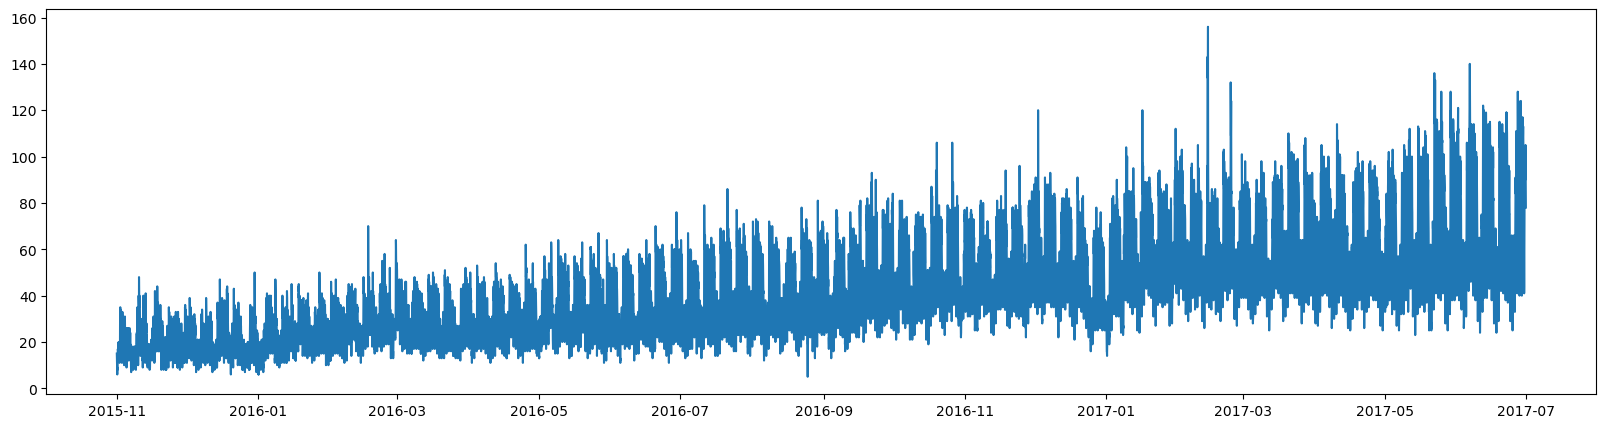

In [5]:
joc = junction_data[1] # joc: junction of choice
plt.figure(figsize=(20,5))
plt.plot(joc.index,joc['Vehicles'])
joc

In [6]:
def create_lstm_data(dataframe, first, last, n=7):
    first = str_to_datetime(first)
    last  = str_to_datetime(last)
    target = first
    dates = []
    X, Y = [], []
    last_time = False
    while True:
        df_subset = dataframe.loc[:target].tail(n+1)
        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target}')
            return
        values = df_subset['Vehicles'].to_numpy()
        x, y = values[:-1], values[-1]
        dates.append(target)
        X.append(x)
        Y.append(y)
        next_week = dataframe.loc[target:target+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        hour = (next_datetime_str.split('T')[1]).split(':')[0]
        next = datetime.datetime(hour = int(hour), day=int(day), month=int(month), year=int(year))
        if last_time:
            break
        target = next
        if target == last:
            last_time = True
    ret = pd.DataFrame({})
    ret['Target Date'] = dates
    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret[f'Target-{n-i}'] = X[:, i]
    ret['Target'] = Y
    return ret

In [7]:
def lstm_data_split(lstm_data):
    df_as_np = lstm_data.to_numpy()
    dates = df_as_np[:, 0]
    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
    Y = df_as_np[:, -1]
    return dates, X.astype(np.float32), Y.astype(np.float32)

C:\Users\tianx\AppData\Local\Temp\ipykernel_25616\11814367.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ret[f'Target-{n-i}'] = X[:, i]
C:\Users\tianx\AppData\Local\Temp\ipykernel_25616\11814367.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ret[f'Target-{n-i}'] = X[:, i]
C:\Users\tianx\AppData\Local\Temp\ipykernel_25616\11814367.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at onc

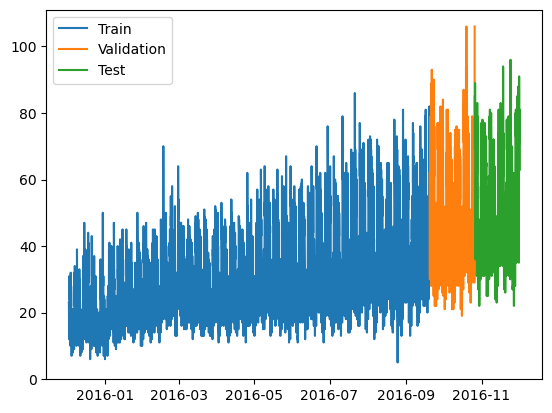

In [8]:
lstm_data = create_lstm_data(joc, '2015-12-03 00:00:00', '2016-12-02 00:00:00', n=168)
dates, X, y = lstm_data_split(lstm_data)
dates.shape, X.shape, y.shape

dates_train,X_train,y_train = dates[:int(len(dates)*0.8)],X[:int(len(dates)*0.8)],y[:int(len(dates)*0.8)]
dates_test,X_test,y_test = dates[int(len(dates)*0.9):],X[int(len(dates)*0.9):],y[int(len(dates)*0.9):]
dates_val,X_val,y_val = dates[int(len(dates)*0.8):int(len(dates)*0.9)], X[int(len(dates)*0.8):int(len(dates)*0.9)], y[int(len(dates)*0.8):int(len(dates)*0.9)]

plt.plot(dates_train,y_train)
plt.plot(dates_val,y_val)
plt.plot(dates_test,y_test)

plt.legend(["Train", "Validation", "Test"])

In [9]:
model = Sequential([
        layers.Input((168, 1)),
        layers.LSTM(64),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_squared_error'])

model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=100)

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 777.4642 - mean_squared_error: 777.4642 - val_loss: 84.3859 - val_mean_squared_error: 84.3859
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 22.5040 - mean_squared_error: 22.5040 - val_loss: 53.4772 - val_mean_squared_error: 53.4772
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 18.9008 - mean_squared_error: 18.9008 - val_loss: 42.5392 - val_mean_squared_error: 42.5392
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 16.5844 - mean_squared_error: 16.5844 - val_loss: 39.7852 - val_mean_squared_error: 39.7852
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 15.3542 - mean_squared_error: 15.3542 - val_loss: 36.3000 - val_mean_squared_error: 36.3000
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 13.8061 - mean_squared_error: 13.8061 - val_loss: 39.7919 - val_mean_squared_error: 39.7919
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - loss: 14.5426 - me

219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


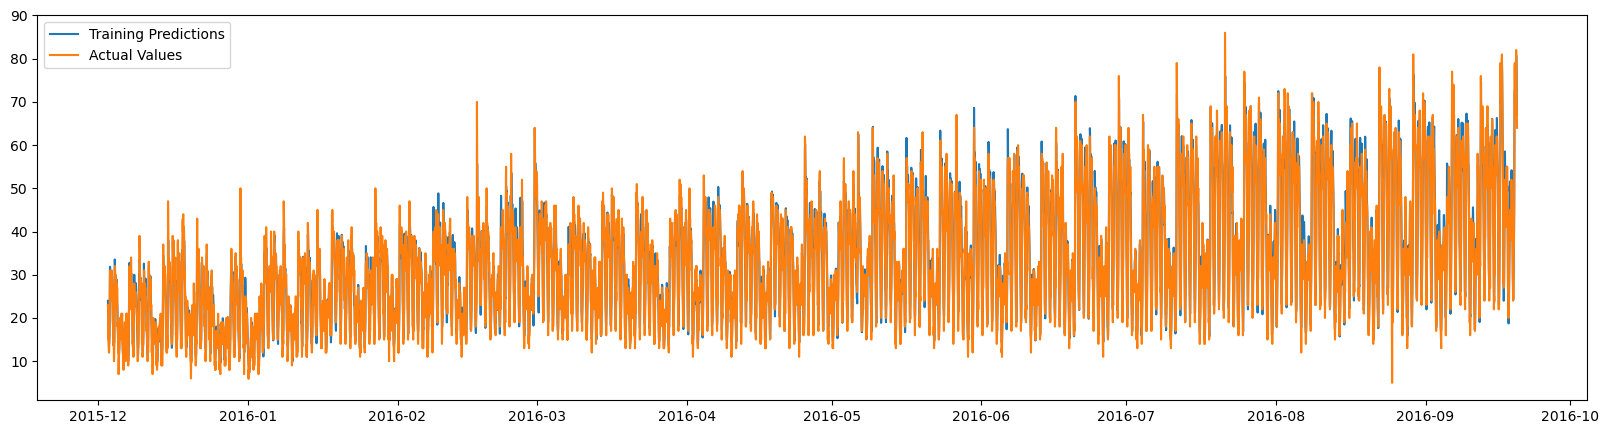

In [10]:
train_predictions = model.predict(X_train).flatten()

plt.figure(figsize=(20,5))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Actual Values'])
plt.savefig('./Result/training_predictions_vs_actual_values.png', dpi=300)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


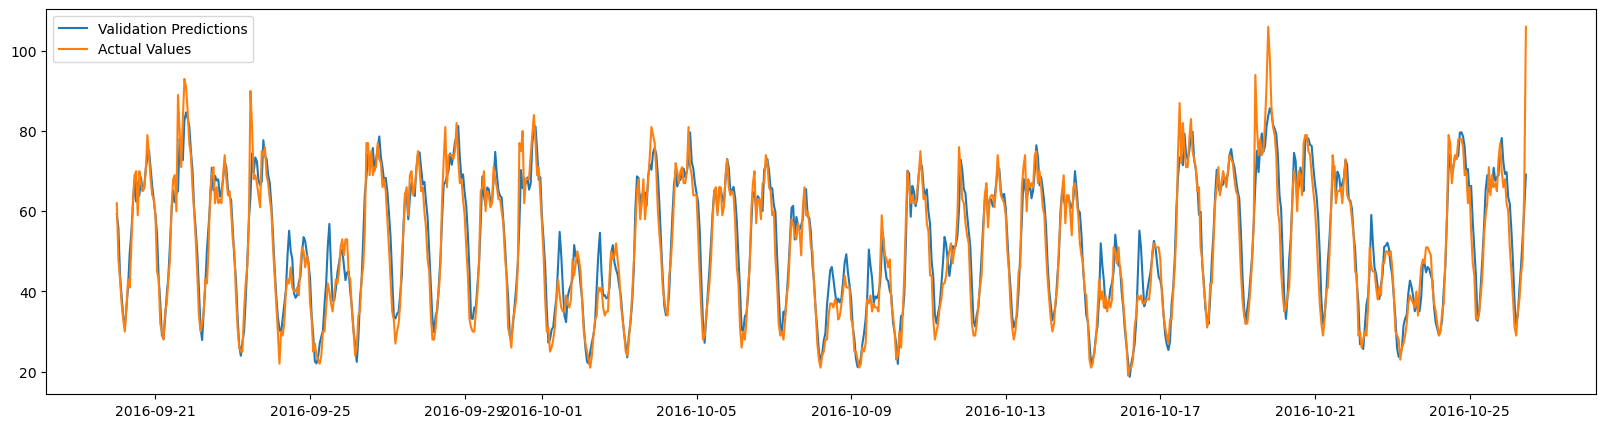

In [11]:
val_predictions = model.predict(X_val).flatten()

plt.figure(figsize=(20,5))
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Actual Values'])
plt.savefig('./Result/validation_predictions_vs_actual_values.png', dpi=300)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


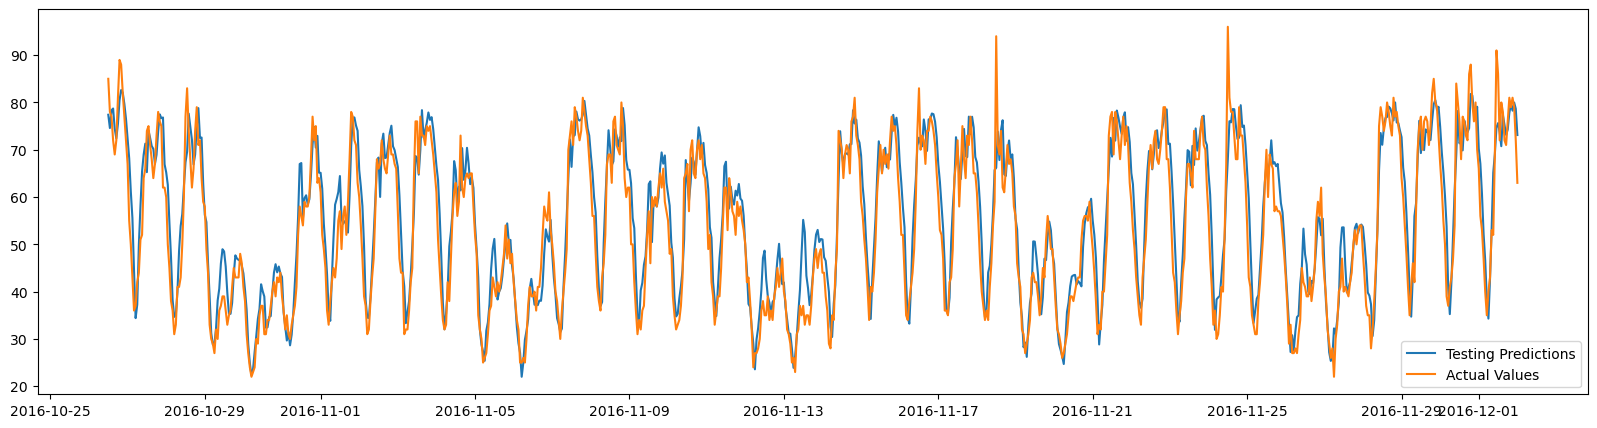

In [12]:
test_predictions = model.predict(X_test).flatten()

plt.figure(figsize=(20,5))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Actual Values'])
plt.savefig('./Result/testing_predictions_vs_actual_values.png', dpi=300)

In [16]:
# Use the trained LSTM model to predict future values recursively

def predict_future_with_lstm_model(model, last_known_window, last_date, n_days_ahead=30):
    n_hours = n_days_ahead * 24
    future_dates = []
    for i in range(n_hours):
        if i == 0:
            next_date = last_date + datetime.timedelta(hours=1)
        else:
            next_date = future_dates[-1] + datetime.timedelta(hours=1)
        future_dates.append(next_date)
    
    future_predictions = []
    prediction_window = deepcopy(last_known_window)
    for i in range(n_hours):
        next_prediction = model.predict(np.array([prediction_window]), verbose=0).flatten()[0]
        clean_prediction(next_prediction, future_dates, i)
        future_predictions.append(next_prediction)
        prediction_window = np.roll(prediction_window, -1, axis=0)
        prediction_window[-1] = next_prediction
    
    return np.array(future_predictions), future_dates

def visualize_traffic_predictions(model, X_train, y_train, X_val, y_val, X_test, y_test, 
                                 dates_train, dates_val, dates_test,
                                 train_predictions, val_predictions, test_predictions,
                                 n_days_ahead):
    last_date = dates_test[-1]
    last_window = X_test[-1]
    future_predictions, future_dates = predict_future_with_lstm_model(
        model=model,
        last_known_window=last_window,
        last_date=last_date,
        n_days_ahead=n_days_ahead
    )
    print(f"Last test date: {dates_test[-1]}")
    print(f"First future date: {future_dates[0]}")
    print(f"Last future date: {future_dates[-1]}")
    plt.figure(figsize=(20, 8))
    plt.plot(future_dates, future_predictions, 'm-', linewidth=1.5, label='Future Predictions')
    plt.title('Future Traffic Predictions')
    plt.xlabel('Date')
    plt.ylabel('Number of Vehicles')
    plt.grid(True, alpha=0.3)
    date_form = DateFormatter("%m-%d %H:%M")
    plt.gca().xaxis.set_major_formatter(date_form)
    plt.xticks(rotation=45)
    all_data = np.concatenate([y_train, y_val, y_test])
    y_min = max(0, min(np.min(all_data), np.min(future_predictions)) - 5)
    y_max = max(np.max(all_data), np.max(future_predictions)) + 5
    plt.ylim(y_min, y_max)
    plt.axvline(x=last_date, color='k', linestyle='--', alpha=0.5)
    plt.text(last_date, y_max*0.95, 'Forecast Start', horizontalalignment='right')
    plt.tight_layout()
    plt.savefig('./Result/future_traffic_prediction_with_lstm.png', dpi=300)
    return future_predictions, future_dates

def clean_prediction(next_prediction,future_dates, current_hour):
    hour_of_day = future_dates[current_hour].hour
    if hour_of_day >= 22 or hour_of_day < 6:
        next_prediction = next_prediction * 0.4
    elif 7 <= hour_of_day <= 9:
        next_prediction = next_prediction * 2.5
    elif 16 <= hour_of_day <= 19:
        next_prediction = next_prediction * 2.5
    day_of_week = future_dates[current_hour].weekday()
    if day_of_week >= 5:
        next_prediction = next_prediction * 0.8 
    next_prediction = next_prediction + np.random.normal(0, next_prediction * 0.1)

Last test date: 2016-12-02 00:00:00
First future date: 2016-12-02 01:00:00
Last future date: 2016-12-05 00:00:00


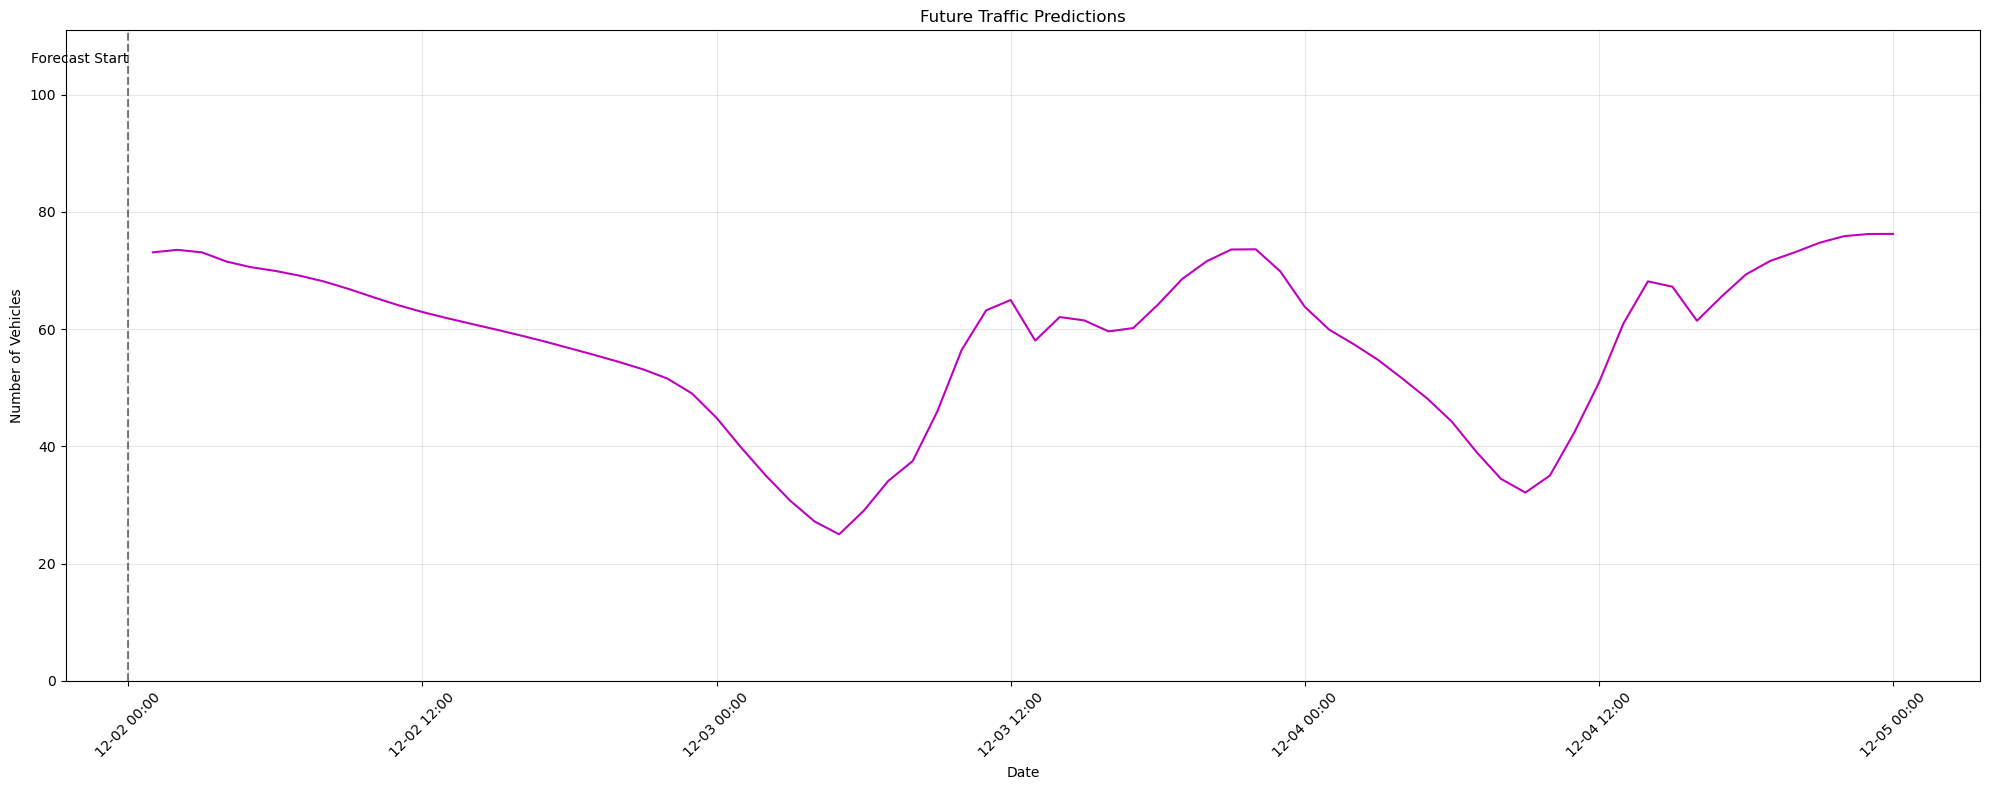

In [21]:
future_predictions, future_dates = visualize_traffic_predictions(
    model=model,
    X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val,
    X_test=X_test, y_test=y_test,
    dates_train=dates_train,
    dates_val=dates_val,
    dates_test=dates_test,
    train_predictions=train_predictions,
    val_predictions=val_predictions,
    test_predictions=test_predictions,
    n_days_ahead=3
)

In [15]:
df = pd.DataFrame({'Time': future_dates, 'Prediction': future_predictions})
df.to_csv('./Result./future_traffic_predictions.csv', index=False)